In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys
from scipy import stats

In [3]:
import json
plt_properties = json.load(open('utils/plt_properties.json'))
fig_width = plt_properties['fig_width']
plt.rcParams.update(plt_properties['plt_params'])

In [4]:
sys.path.append(os.path.join(os.getcwd(), 'utils'))
from correlation import plot_regression
from variables import min_pred_col, vol_pred_col, target_col

# 4) Intraindividual variation 

In [5]:
df = pd.read_csv('../Data/dataset_mlr.csv')

/tmp/ipykernel_69346/900100850.py:1: DtypeWarning: Columns (12,22,23,24,25,35,36,37,38,39,44,48,49,53,54,55,61,72,76,121,122,124,125,127,136,138,139,140,141,142,143,144,152,157,158,159,161,162,163,210,216,218,219,221,233,251,252,254,503,509,511,513,515,519,523,525,527,529) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../Data/dataset_mlr.csv')


In [6]:
df_j = df[df['source'] == 'sk1'].join(
    df[df['source'] == 'sk2'].set_index('sk1_id'),
    on='sk1_id', how='inner',
    lsuffix='_sk1', rsuffix='_sk2')

In [7]:
print(f'Number of participants with 2 measurements: {len(df_j)}.')

Number of participants with 2 measurements: 667.


## 4.1) Measurements correlation

In [8]:
np.corrcoef(df[min_pred_col], df[target_col]) ** 2

array([[1.        , 0.43641086],
       [0.43641086, 1.        ]])

In [9]:
cols = {
    '{}_min': 'Urine collection duration', '{}_ml': 'Urine collection volume',
    'una_{}_mmol': 'Urinary sodium', 'uk_{}_mmol': 'Urinary potassium', 'ucrt_{}_umol': 'Urinary creatinine',
}
data = {'Measurement': [], 'R 24-hour': [], 'R 24-hour (corr)': [], 'R Day-time': [], 'R Night-time': []}
for col in cols:
    data['Measurement'].append(cols[col])
    for pref, lab in [('u24', '24-hour'), ('u24corr', '24-hour (corr)'), ('ud', 'Day-time'), ('un', 'Night-time')]:
        corr_p = np.corrcoef(df_j[col.format(pref) + '_sk2'], df_j[col.format(pref) + '_sk1'])[0, 1]
        corr_s = stats.spearmanr(df_j[col.format(pref) + '_sk2'], df_j[col.format(pref) + '_sk1']).correlation
        data[f'R {lab}'].append(str(round(corr_p, 3)).ljust(5, '0') + " | " + str(round(corr_s, 3)).ljust(5, '0'))
r2_stats = pd.DataFrame(data, dtype=object).set_index('Measurement')
r2_stats.to_csv('../Figures/intraindividual/intraindiv_stats.csv', encoding='utf8')
r2_stats

/home/arthur/miniconda3/envs/hiwi/lib/python3.11/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/arthur/miniconda3/envs/hiwi/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


,R 24-hour,R 24-hour (corr),R Day-time,R Night-time
Measurement,,,,
Urine collection duration,0.059 | 0.074,nan00 | nan00,0.163 | 0.203,0.283 | 0.300
Urine collection volume,0.583 | 0.546,0.572 | 0.539,0.537 | 0.507,0.387 | 0.394
Urinary sodium,0.358 | 0.363,0.357 | 0.361,0.368 | 0.359,0.236 | 0.344
Urinary potassium,0.410 | 0.426,0.402 | 0.422,0.372 | 0.376,0.182 | 0.311
Urinary creatinine,0.681 | 0.758,0.677 | 0.767,0.592 | 0.637,0.343 | 0.614


In [10]:
table_rows = {
    'una_un_mmol': 'Night-time', 'una_un_mmol_norm_min': 'Night-time - ND', 'una_un_mmol_norm_vol': 'Night-time - NMV',
    'una_u24_mmol': '24-hour', 'una_u24corr_mmol': '24-hour (corr)'
}
data = {'': [], 'R 24-hour': [], 'R 24-hour (corr)': []}
for col_row, name in table_rows.items():
    data[''].append(name)
    for col_col, lab in [('una_u24_mmol', '24-hour'), ('una_u24corr_mmol', '24-hour (corr)')]:
        corr_p = np.corrcoef(df_j[col_row + '_sk2'], df_j[col_col + '_sk1'])[0, 1]
        corr_s = stats.spearmanr(df_j[col_row + '_sk2'], df_j[col_col + '_sk1']).correlation
        data[f'R {lab}'].append(str(round(corr_p, 3)).ljust(5, '0') + " | " + str(round(corr_s, 3)).ljust(5, '0'))
r2_night_na_stats = pd.DataFrame(data, dtype=object).set_index('')
r2_night_na_stats.to_csv('../Figures/intraindividual/intraindiv_stats_na_night.csv', encoding='utf8')
r2_night_na_stats

,R 24-hour,R 24-hour (corr)
,,
Night-time,0.177 | 0.223,0.180 | 0.219
Night-time - ND,0.190 | 0.244,0.192 | 0.240
Night-time - NMV,0.177 | 0.223,0.180 | 0.219
24-hour,0.358 | 0.363,0.360 | 0.363
24-hour (corr),0.354 | 0.360,0.357 | 0.361


## 4.2) Errors correlation

### 4.2.1) Duration normalization

In [11]:
abs_err1 = df_j[target_col + '_sk1'] - df_j[min_pred_col + '_sk1']
abs_err2 = df_j[target_col + '_sk2'] - df_j[min_pred_col + '_sk2']
rel_err1 = abs_err1 / df_j[target_col + '_sk1']
rel_err2 = abs_err2 / df_j[target_col + '_sk2']

Coeffs: [0.22078214]
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.2208      0.041      5.371      0.000       0.140       0.302
$R^2$=0.041569685387109034
Coeffs: [0.29693371]
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.2969      0.043      6.869      0.000       0.212       0.382
$R^2$=0.0662440299317747


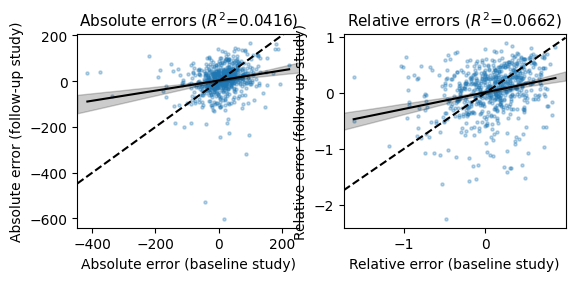

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(fig_width, 0.4 * fig_width))

r_squared = plot_regression(abs_err1, abs_err2, ax=ax[0])
ax[0].set(xlabel='Absolute error (baseline study)', ylabel='Absolute error (follow-up study)',
          title=f'Absolute errors ($R^2$={round(r_squared, 4)})')
print(f'$R^2$={r_squared}')

r_squared = plot_regression(rel_err1, rel_err2, ax=ax[1])
ax[1].set(xlabel='Relative error (baseline study)', ylabel='Relative error (follow-up study)',
          title=f'Relative errors ($R^2$={round(r_squared, 4)})')
print(f'$R^2$={r_squared}')

### 4.2.2) Mean volume normalization

In [13]:
abs_err1 = df_j[target_col + '_sk1'] - df_j[vol_pred_col + '_sk1']
abs_err2 = df_j[target_col + '_sk2'] - df_j[vol_pred_col + '_sk2']
rel_err1 = abs_err1 / df_j[target_col + '_sk1']
rel_err2 = abs_err2 / df_j[target_col + '_sk2']

Coeffs: [0.21950988]
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.2195      0.038      5.789      0.000       0.145       0.294
$R^2$=0.047973715443224596
Coeffs: [0.30921633]
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.3092      0.042      7.441      0.000       0.228       0.391
$R^2$=0.07685975912462195


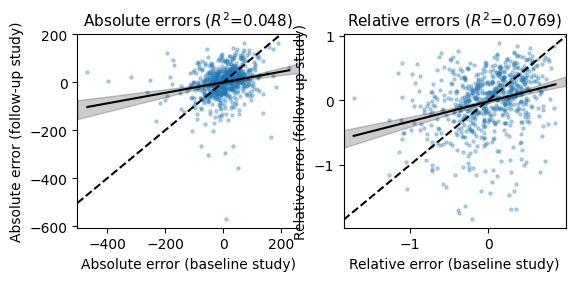

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(fig_width, 0.4 * fig_width))

r_squared = plot_regression(abs_err1, abs_err2, ax=ax[0])
ax[0].set(xlabel='Absolute error (baseline study)', ylabel='Absolute error (follow-up study)',
          title=f'Absolute errors ($R^2$={round(r_squared, 4)})')
print(f'$R^2$={r_squared}')

r_squared = plot_regression(rel_err1, rel_err2, ax=ax[1])
ax[1].set(xlabel='Relative error (baseline study)', ylabel='Relative error (follow-up study)',
          title=f'Relative errors ($R^2$={round(r_squared, 4)})')
print(f'$R^2$={r_squared}')